In [2]:
%load_ext tensorboard

import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds


from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [77]:
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.2))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.2))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dropout(0.2))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= "adam",
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy'])

In [78]:
batch_size = 64
img_height = 100
img_width = 100

In [79]:
num_classes = 5
model = AlexNet((img_height, img_width, 3), num_classes)
model.summary()

Model: "alex_net_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 23, 23, 96)        34944     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 11, 11, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 11, 11, 256)       614656    
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 5, 5, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 5, 5, 384)         885120    
                                                                 
 conv2d_48 (Conv2D)          (None, 5, 5, 384)         1

In [67]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir+'/flower_photos')

In [68]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [69]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [70]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [71]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.numpy())

(64, 100, 100, 3)
[1 0 4 3 1 2 0 4 4 1 1 4 3 1 1 4 0 3 3 1 1 1 3 2 4 4 4 3 2 2 0 3 0 2 4 4 4
 1 1 1 1 1 3 0 1 2 3 0 1 3 0 0 4 3 4 2 4 1 4 1 4 0 2 0]


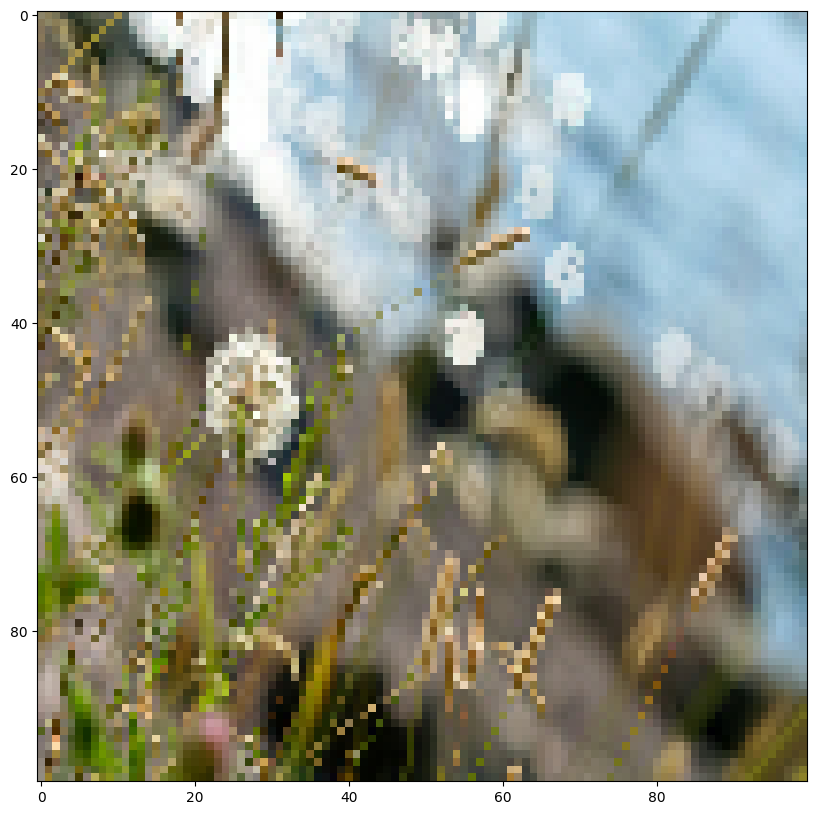

In [72]:
plt.figure(figsize=(10, 10))
plt.imshow(image[0].numpy().astype("uint8"))

In [73]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


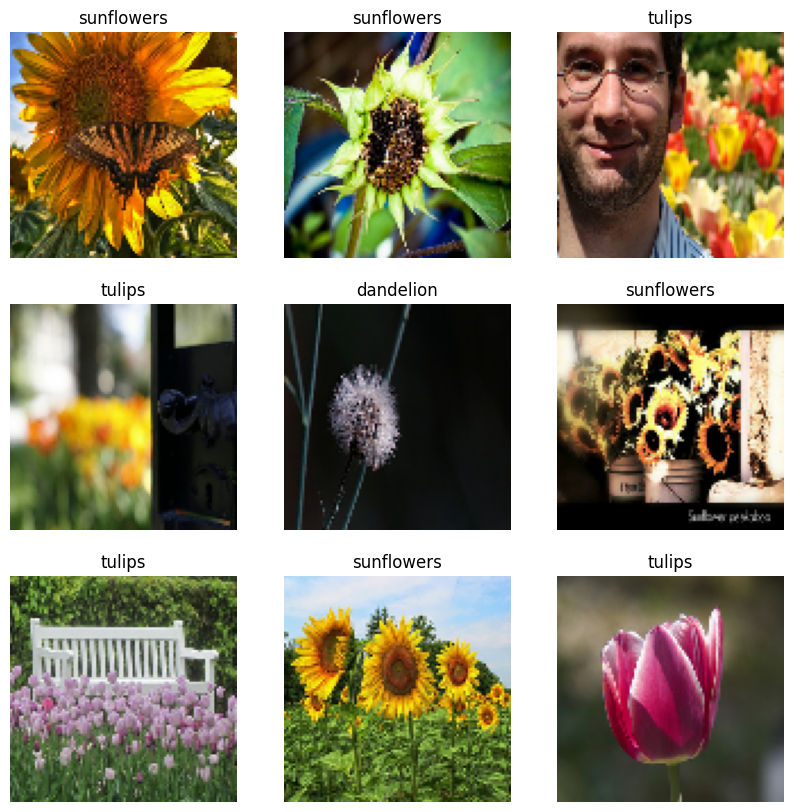

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [74]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [75]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [80]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50)

Epoch 1/50
46/46 [==============================] - 15s 309ms/step - loss: 81.5198 - accuracy: 0.2173 - val_loss: 1.6048 - val_accuracy: 0.2398
Epoch 2/50
46/46 [==============================] - 15s 321ms/step - loss: 1.6015 - accuracy: 0.2432 - val_loss: 1.6016 - val_accuracy: 0.2398
Epoch 3/50
46/46 [==============================] - 15s 330ms/step - loss: 1.6020 - accuracy: 0.2449 - val_loss: 1.6018 - val_accuracy: 0.2398
Epoch 4/50
46/46 [==============================] - 15s 332ms/step - loss: 1.6002 - accuracy: 0.2459 - val_loss: 1.6023 - val_accuracy: 0.2398
Epoch 5/50
46/46 [==============================] - 18s 394ms/step - loss: 1.6015 - accuracy: 0.2446 - val_loss: 1.6015 - val_accuracy: 0.2398
Epoch 6/50
46/46 [==============================] - 18s 391ms/step - loss: 1.6012 - accuracy: 0.2452 - val_loss: 1.6016 - val_accuracy: 0.2398
Epoch 7/50
46/46 [==============================] - 18s 389ms/step - loss: 1.6008 - accuracy: 0.2476 - val_loss: 1.6018 - val_accuracy: 0.239

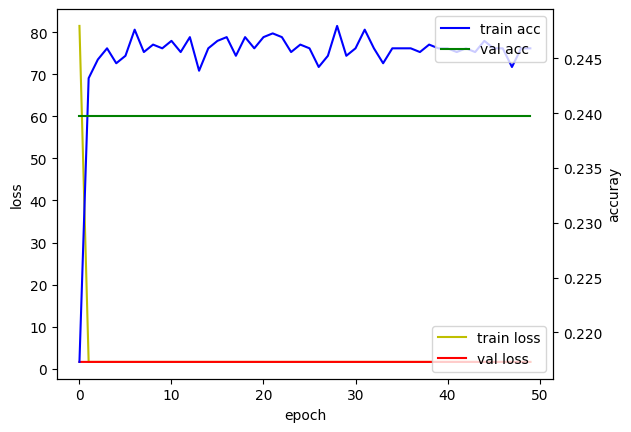

In [81]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history1.history['loss'], 'y', label='train loss')
loss_ax.plot(history1.history['val_loss'], 'r', label='val loss')
acc_ax.plot(history1.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history1.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='lower right')
acc_ax.legend(loc='upper right')
plt.show()

In [82]:
loss_and_metrics = model.evaluate(val_ds, batch_size=32)
print('## 손실과 정확도 평가  ##')
print(loss_and_metrics)

12/12 [==============================] - 2s 128ms/step - loss: 1.6018 - accuracy: 0.2398
## 손실과 정확도 평가  ##
[1.6017512083053589, 0.23978202044963837]
